# Predicting Movie Success
- Numann Malik

Objective: We will create a Linear Regression model to predict revenue and make recommendations on how to create a successful movie.

In [1]:
# Import relevant libraries
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Function Definitions


In [2]:
## Function to obtain genre names as a list 
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [ ]:
## Function to evaluate OLS regression residuals
def evaluate_ols(result,X_train_df,y_train)
    """Plots a Q-Q plot and residual plot for a statsmodels OLS regression"""
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2, figsize=(12,5))
    
    ## Normality
    sm.graphics.qqplot(resid, line='45', fit=True, ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

## Load and Inspect Data

In [3]:
df = pd.read_csv('Data/final_tmdb_data_combined.csv.gz',lineterminator='\n')

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60130 non-null  object 
 1   adult                  60130 non-null  float64
 2   backdrop_path          36994 non-null  object 
 3   belongs_to_collection  3738 non-null   object 
 4   budget                 60130 non-null  float64
 5   genres                 60130 non-null  object 
 6   homepage               14776 non-null  object 
 7   id                     60130 non-null  float64
 8   original_language      60130 non-null  object 
 9   original_title         60130 non-null  object 
 10  overview               58761 non-null  object 
 11  popularity             60130 non-null  float64
 12  poster_path            54382 non-null  object 
 13  production_companies   60130 non-null  object 
 14  production_countries   60130 non-null  object 
 15  re

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.4,21.0,NaN
1,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,4.4,7.0,NaN
2,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.0,0.0,NaN
3,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,1868.0,PG
4,tt0118852,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,...,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.9,46.0,R


In [5]:
## remove ids that are 0 and reset index
df = df.loc[df['imdb_id']!='0']
df = df.reset_index(drop=True)

imdb_id                      0
adult                        0
backdrop_path            23136
belongs_to_collection    56392
budget                       0
genres                       0
homepage                 45354
id                           0
original_language            0
original_title               0
overview                  1369
popularity                   0
poster_path               5748
production_companies         0
production_countries         0
release_date              1052
revenue                      0
runtime                    832
spoken_languages             0
status                       0
tagline                  38051
title                        0
video                        0
vote_average                 0
vote_count                   0
certification            45506
dtype: int64

## Feature Engineering

In [15]:
## Exclude columns unlikely relevant to revenue
drop_cols = ['backdrop_path','original_title','overview',
            'poster_path','tagline','id','homepage',
            'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,status,title,vote_average,vote_count,certification
0,tt0113026,0.0,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,Released,The Fantasticks,5.4,21.0,NaN
1,tt0113092,0.0,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,Released,For the Cause,4.4,7.0,NaN
2,tt0116391,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.341,[],2000-04-14,0.0,152.0,Released,Gang,0.0,0.0,NaN
3,tt0118694,0.0,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,Released,In the Mood for Love,8.1,1868.0,PG
4,tt0118852,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Released,Chinese Coffee,6.9,46.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",2021-09-08,0.0,118.0,Released,Heiko's World,0.0,0.0,NaN
60126,tt9896876,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",2021-11-19,0.0,101.0,Released,India Sweets and Spices,6.0,2.0,PG-13
60127,tt9898844,0.0,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",2022-01-21,0.0,91.0,Released,The Hunting,4.9,20.0,NaN
60128,tt9900940,0.0,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,Released,The Scrapper,6.0,2.0,NaN


In [16]:
## Use .notna() to convert 'belongs_to_collection' into Boolean feature
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,status,title,vote_average,vote_count,certification
0,tt0113026,0.0,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,Released,The Fantasticks,5.4,21.0,NaN
1,tt0113092,0.0,False,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,Released,For the Cause,4.4,7.0,NaN
2,tt0116391,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.341,[],2000-04-14,0.0,152.0,Released,Gang,0.0,0.0,NaN
3,tt0118694,0.0,False,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,Released,In the Mood for Love,8.1,1868.0,PG
4,tt0118852,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Released,Chinese Coffee,6.9,46.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",2021-09-08,0.0,118.0,Released,Heiko's World,0.0,0.0,NaN
60126,tt9896876,0.0,False,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",2021-11-19,0.0,101.0,Released,India Sweets and Spices,6.0,2.0,PG-13
60127,tt9898844,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}]",421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",2022-01-21,0.0,91.0,Released,The Hunting,4.9,20.0,NaN
60128,tt9900940,0.0,False,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,Released,The Scrapper,6.0,2.0,NaN


In [17]:
# Explode genres column using get_genre_name function
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')

In [18]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

In [19]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)  

In [20]:
## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,status,...,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,Released,...,False,False,False,False,False,False,False,False,False,False
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,Released,...,False,False,False,False,False,False,False,False,False,False
2,tt0116391,0.0,False,0.0,1.341,[],2000-04-14,0.0,152.0,Released,...,False,False,False,False,False,False,False,False,False,False
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,Released,...,False,False,False,False,False,False,False,False,False,False
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Released,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",2021-09-08,0.0,118.0,Released,...,False,False,False,False,False,False,False,False,False,False
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",2021-11-19,0.0,101.0,Released,...,False,False,False,False,False,False,False,False,False,False
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",2022-01-21,0.0,91.0,Released,...,False,True,False,False,False,False,False,False,False,False
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,Released,...,False,False,True,False,False,False,False,False,False,False


In [21]:
# Clean MPAA rating feature
df['certification'] = df['certification'].str.strip()

repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'] = df['certification'].fillna('NR')
df['certification'].value_counts(dropna=False)

NR       48777
R         6098
PG-13     3225
PG        1432
G          442
NC-17      156
Name: certification, dtype: int64

In [22]:
# Splitting release_date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

## drop original feature
df = df.drop(columns=['release_date'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,status,title,...,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",0.0,86.0,Released,The Fantasticks,...,False,False,False,False,False,False,False,2000.0,9.0,22.0
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",0.0,100.0,Released,For the Cause,...,False,False,False,False,False,False,False,2000.0,11.0,15.0
2,tt0116391,0.0,False,0.0,1.341,[],0.0,152.0,Released,Gang,...,False,False,False,False,False,False,False,2000.0,4.0,14.0
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,Released,In the Mood for Love,...,False,False,False,False,False,False,False,2000.0,9.0,29.0
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",0.0,99.0,Released,Chinese Coffee,...,False,False,False,False,False,False,False,2000.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",0.0,118.0,Released,Heiko's World,...,False,False,False,False,False,False,False,2021.0,9.0,8.0
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",0.0,101.0,Released,India Sweets and Spices,...,False,False,False,False,False,False,False,2021.0,11.0,19.0
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",0.0,91.0,Released,The Hunting,...,False,False,False,False,False,False,False,2022.0,1.0,21.0
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",0.0,87.0,Released,The Scrapper,...,False,False,False,False,False,False,False,2021.0,12.0,7.0


In [23]:
## Filter to keep only Released movies
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,...,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",0.0,86.0,The Fantasticks,5.4,...,False,False,False,False,False,False,False,2000.0,9.0,22.0
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",0.0,100.0,For the Cause,4.4,...,False,False,False,False,False,False,False,2000.0,11.0,15.0
2,tt0116391,0.0,False,0.0,1.341,[],0.0,152.0,Gang,0.0,...,False,False,False,False,False,False,False,2000.0,4.0,14.0
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,In the Mood for Love,8.1,...,False,False,False,False,False,False,False,2000.0,9.0,29.0
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",0.0,99.0,Chinese Coffee,6.9,...,False,False,False,False,False,False,False,2000.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",0.0,118.0,Heiko's World,0.0,...,False,False,False,False,False,False,False,2021.0,9.0,8.0
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",0.0,101.0,India Sweets and Spices,6.0,...,False,False,False,False,False,False,False,2021.0,11.0,19.0
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",0.0,91.0,The Hunting,4.9,...,False,False,False,False,False,False,False,2022.0,1.0,21.0
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",0.0,87.0,The Scrapper,6.0,...,False,False,False,False,False,False,False,2021.0,12.0,7.0


In [24]:
## Filter out movies with no financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,...,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,In the Mood for Love,8.1,...,False,False,False,False,False,False,False,2000.0,9.0,29.0
10,tt0120467,0.0,False,120000.0,5.300,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",14904.0,87.0,Vulgar,5.5,...,False,False,False,False,False,False,False,2002.0,4.0,26.0
12,tt0120630,0.0,True,45000000.0,51.339,"[{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...",224834564.0,84.0,Chicken Run,6.7,...,False,True,False,False,False,False,False,2000.0,6.0,21.0
15,tt0120753,0.0,False,8000000.0,8.371,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",105983.0,122.0,The Million Dollar Hotel,5.9,...,False,False,False,False,False,False,False,2000.0,2.0,9.0
16,tt0120755,0.0,True,125000000.0,26.731,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",546388105.0,123.0,Mission: Impossible II,6.1,...,False,False,False,False,False,False,False,2000.0,5.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60053,tt9639470,0.0,False,43000000.0,157.932,"[{'id': 10146, 'logo_path': '/xnFIOeq5cKw09kCW...",22957625.0,117.0,Last Night in Soho,7.5,...,False,False,True,False,False,False,False,2021.0,10.0,21.0
60058,tt9664108,0.0,False,20000000.0,91.077,"[{'id': 148185, 'logo_path': None, 'name': 'No...",4284903.0,108.0,Voyagers,6.1,...,False,False,False,False,False,False,False,2021.0,4.0,8.0
60094,tt9784798,0.0,False,26000000.0,16.946,"[{'id': 79426, 'logo_path': '/8aEC7xem9YwHNCDo...",6416063.0,126.0,Judas and the Black Messiah,7.4,...,True,False,False,False,False,False,False,2021.0,2.0,12.0
60106,tt9844322,0.0,False,17516235.0,8.904,"[{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...",19002036.0,120.0,Kaamelott: The First Chapter,6.9,...,False,False,False,False,False,False,False,2021.0,7.0,21.0


In [30]:
##
df = df.drop(columns=['imdb_id','title','production_companies'])

## Test Assumptions

In [25]:
## saving list of numeric features to slice for pairplot
num_selector = make_column_selector(dtype_include='number')
cols = num_selector(df.drop(columns='revenue'))
len(cols)

9

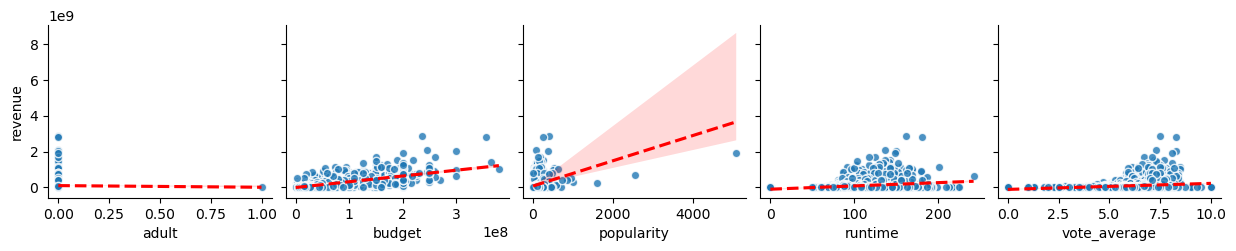

In [26]:
## Making a pairplot with regression lines (first five features)
sns.pairplot(df,y_vars='revenue',kind='reg',x_vars=cols[:5],
             plot_kws=dict(line_kws={'color':'red','ls':'--'},scatter_kws={'edgecolor':'white','lw':1}));

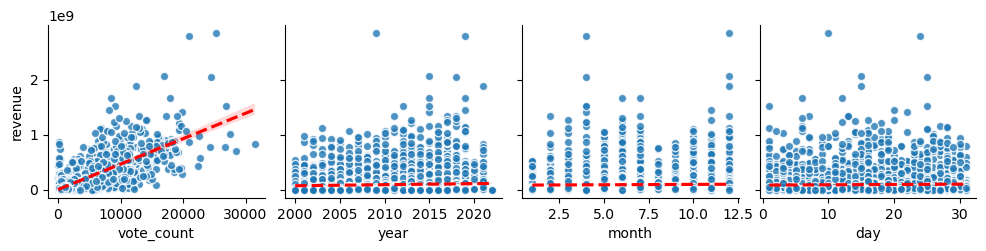

In [27]:
## Making a pairplot with regression lines (next 4 features)
sns.pairplot(df,y_vars='revenue',kind='reg',x_vars=cols[5:],
             plot_kws=dict(line_kws={'color':'red','ls':'--'},scatter_kws={'edgecolor':'white','lw':1}));

In [28]:
## dropping nonlinear features
df= df.drop(columns=['adult','year','month','day'])

In [29]:
## Checking Multicollinearity
corr = df.corr().abs()
corr

/var/folders/50/3xbvh4ss3131ch53yqb8sydr0000gn/T/ipykernel_4597/2666930916.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr().abs()


,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,Genre_Comedy,Genre_Music,Genre_Romance,...,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
belongs_to_collection,1.000000,0.289485,0.178151,0.386398,0.006254,0.053712,0.309483,0.011435,0.029894,0.127830,...,0.130570,0.120561,0.027803,0.085251,0.141739,0.014152,0.016488,0.052764,NaN,0.019688
budget,0.289485,1.000000,0.298774,0.759183,0.215871,0.140851,0.640697,0.045344,0.037264,0.122304,...,0.282590,0.128284,0.022396,0.008416,0.210284,0.034024,0.029263,0.019078,NaN,0.025773
popularity,0.178151,0.298774,1.000000,0.364752,0.076543,0.129881,0.314169,0.033940,0.020038,0.058641,...,0.131501,0.005208,0.014250,0.024375,0.057280,0.010830,0.003326,0.014027,NaN,0.009716
revenue,0.386398,0.759183,0.364752,1.000000,0.206723,0.208700,0.783547,0.026962,0.017153,0.082313,...,0.226236,0.072089,0.049493,0.033439,0.161876,0.036644,0.011232,0.014046,NaN,0.017745
runtime,0.006254,0.215871,0.076543,0.206723,1.000000,0.288563,0.216513,0.219880,0.014723,0.088546,...,0.012660,0.175325,0.000244,0.194491,0.194224,0.005992,0.030627,0.129673,NaN,0.030059
vote_average,0.053712,0.140851,0.129881,0.208700,0.288563,1.000000,0.317474,0.091826,0.052984,0.015449,...,0.036022,0.118128,0.034324,0.109073,0.003643,0.009315,0.018151,0.070221,NaN,0.012990
vote_count,0.309483,0.640697,0.314169,0.783547,0.216513,0.317474,1.000000,0.087823,0.030661,0.095203,...,0.186604,0.032918,0.004387,0.033561,0.054569,0.012126,0.015789,0.015097,NaN,0.020979
Genre_Comedy,0.011435,0.045344,0.033940,0.026962,0.219880,0.091826,0.087823,1.000000,0.038671,0.180097,...,0.012498,0.171623,0.362701,0.142641,0.212593,0.160966,0.032599,0.112442,NaN,0.005214
Genre_Music,0.029894,0.037264,0.020038,0.017153,0.014723,0.052984,0.030661,0.038671,1.000000,0.088956,...,0.010748,0.045721,0.098673,0.012830,0.020628,0.046525,0.016414,0.006804,NaN,0.006309
Genre_Romance,0.127830,0.122304,0.058641,0.082313,0.088546,0.015449,0.095203,0.180097,0.088956,1.000000,...,0.033145,0.147915,0.205423,0.041362,0.085338,0.104283,0.040298,0.021625,NaN,0.017535


None of the feature pairs have correlation outside of the (-0.8,0.8) range. So we keep all of them for now except imdb_id and title (which are essentially keys).

## Running the Model

In [31]:
## Preprocessing
y = df['revenue'].copy()
X = df.drop(columns=['revenue']).copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train

,belongs_to_collection,budget,popularity,production_companies,runtime,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,...,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
8296,True,15000000.0,14.335,"[{'id': 711, 'logo_path': '/tEiIH5QesdheJmDAqQ...",95.0,6.9,242.0,PG,False,False,...,False,False,False,False,True,False,False,False,False,False
12356,False,3000000.0,12.210,"[{'id': 43, 'logo_path': '/4RgIPr55kBakgupWkzd...",92.0,6.2,307.0,R,True,False,...,False,False,False,False,False,False,False,False,False,False
14088,False,18500000.0,12.889,"[{'id': 11845, 'logo_path': None, 'name': 'Win...",100.0,6.2,1645.0,PG-13,True,False,...,True,False,False,False,False,False,False,False,False,False
16186,False,80000000.0,34.021,"[{'id': 1088, 'logo_path': '/9WOE5AQUXbOtLU6GT...",118.0,6.8,5076.0,R,False,False,...,False,False,True,False,False,False,False,False,False,False
12971,False,33000000.0,26.790,"[{'id': 27351, 'logo_path': None, 'name': 'Mat...",116.0,8.0,8963.0,R,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42885,False,6900000.0,1.571,"[{'id': 104018, 'logo_path': None, 'name': 'Пи...",99.0,2.5,28.0,NR,False,False,...,False,False,False,False,False,False,False,False,False,False
2896,False,250000.0,7.630,"[{'id': 86531, 'logo_path': None, 'name': 'Two...",101.0,5.2,200.0,R,False,False,...,False,True,False,False,False,False,False,False,False,False
24958,True,75000000.0,77.182,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f...",116.0,7.4,13629.0,PG-13,False,False,...,False,False,True,False,False,False,False,False,False,False
33219,False,108000000.0,53.762,"[{'id': 1645, 'logo_path': '/6Ry6uNBaa0IbbSs1X...",141.0,7.7,16953.0,PG-13,False,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['production_companies', 'certification']

In [33]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']

In [34]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                        OneHotEncoder(handle_unknown='ignore',sparse=False)
                        )
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [35]:
preprocessor = make_column_transformer((num_pipe,num_cols),
                                       (cat_pipe,cat_cols),
                                      remainder='passthrough')

In [36]:
## fit the col transformer to learn feature names
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['production_companies', 'certification'])])

In [37]:
# Create list of final features
final_features =[]
final_features.extend(num_cols)
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)
final_features.extend(cat_features)

In [38]:
## Transform as dataframes
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns=final_features,
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         columns=final_features,
                         index=X_test.index)
X_test_df

ValueError: Shape of passed values is (3817, 3484), indices imply (3817, 3464)

In [ ]:
## Adding constants for statsmodels
X_train_df = sm.add_constant(X_train_df,prepend=False)
X_test_df = sm.add_constant(X_test_df,prepend=False)
X_train_df

In [ ]:
## Fitting the Regression Model
model = sm.OLS(y_train,X_train_df)
result = model.fit()
print(result.summary())

In [ ]:
## Evaluate Model
evaluate_ols(result,X_train_df,y_train)

## Diagnosing the Model by iteration

In [ ]:
# Removing outliers
scaler = StandardScaler()
z_rev = scaler.fit_transform(y_train.values.reshape(-1,1))
z_rev = 